# Guide-and-Rescale: Self-Guidance Mechanism for Effective Tuning-Free Real Image Editing

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from omegaconf import OmegaConf

from diffusion_core.guiders import GuidanceEditing
from diffusion_core.utils import load_512, use_deterministic
from diffusion_core import diffusion_models_registry, diffusion_schedulers_registry

In [2]:
use_deterministic()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

We use our implementation of DDIM Scheduler for StableDiffusionPipeline. 

In [3]:
def get_scheduler(scheduler_name):
    if scheduler_name not in diffusion_schedulers_registry:
        raise ValueError(f"Incorrect scheduler type: {scheduler_name}, possible are {diffusion_schedulers_registry}")
    scheduler = diffusion_schedulers_registry[scheduler_name]()
    return scheduler

In [4]:
def get_model(scheduler, model_name, device):
    model = diffusion_models_registry[model_name](scheduler)
    model.to(device)
    return model

In [5]:
scheduler_name = 'ddim_50_eps'
scheduler = get_scheduler(scheduler_name)

model_name = 'stable-diffusion-v1-4'
model = get_model(scheduler, model_name, device)

/home/jovyan/.mlspace/envs/ldm_sasha_2/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


## Inference examples

In [6]:
def show_images(init_image, edit_image, init_prompt, edit_prompt):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    axs[0].imshow(init_image)
    axs[0].axis('off')
    axs[0].set_title('Initial image\nPrompt: \"{}\"'.format(init_prompt), fontsize=10)
    
    axs[1].imshow(edit_image)
    axs[1].axis('off')
    axs[1].set_title('Edited image\nPrompt: \"{}\"'.format(edit_prompt), fontsize=10)
    
    plt.show()

### Configs

We provide different configs for stylisation and non-stylisation types of editing. For local editing a non-stylisation one `ours_nonstyle_best.yaml` is fine, for global editing a stylisation one `ours_style_best.yaml` is fine. These configs require at least about 30 GB on CUDA to run our pipeline. 

We also provide configs for GPUs with less memory: `ours_style_best_colab.yaml` and `ours_nonstyle_best_colab.yaml`. These configs use not all self-attention layers in guiders, and the quality of editing may be slightly worse.



### Stylisation editing example

In [7]:
image_path = "../example_images/face.png"
image = Image.fromarray(load_512(image_path))

init_prompt = "A photo"
edit_prompt = "Anime style face"

config = OmegaConf.load('../configs/ours_style_best.yaml')

In [8]:
guidance = GuidanceEditing(model, config)

In [9]:
res = guidance(image, init_prompt, edit_prompt, verbose=True)

Editing:   0%|          | 0/50 [00:00<?, ?it/s]

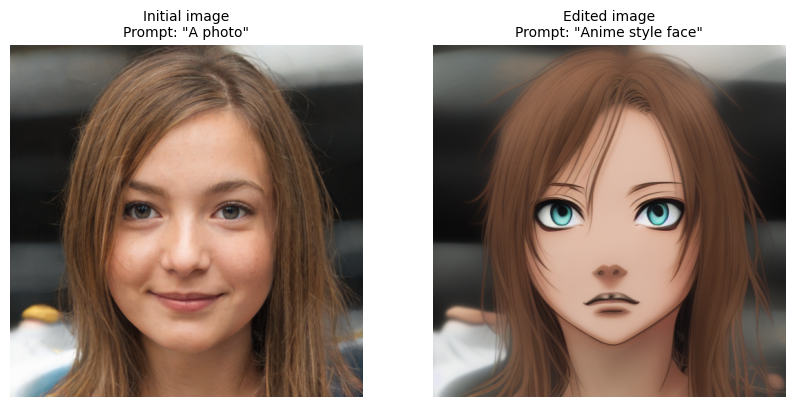

In [10]:
show_images(np.asarray(image), res, init_prompt, edit_prompt)

### Non-stylisation editing example

In [11]:
image_path = "../example_images/zebra.jpeg"
image = Image.fromarray(load_512(image_path))

init_prompt = "A photo of a zebra"
edit_prompt = "A photo of a white horse"

config = OmegaConf.load('../configs/ours_nonstyle_best.yaml')

In [12]:
guidance = GuidanceEditing(model, config)

In [13]:
res = guidance(image, init_prompt, edit_prompt, verbose=True)

Editing:   0%|          | 0/50 [00:00<?, ?it/s]

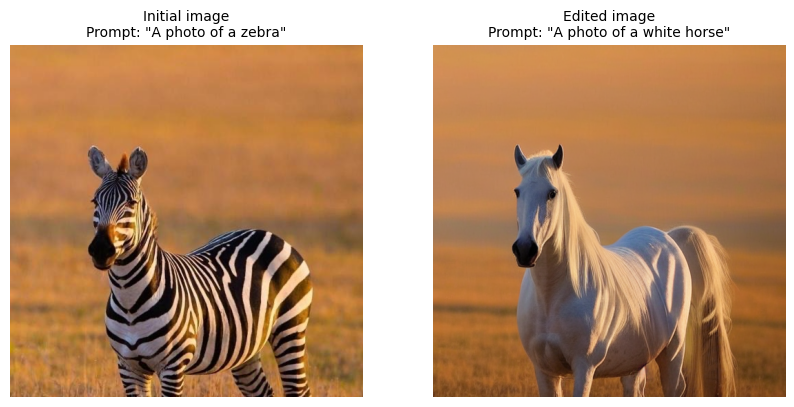

In [14]:
show_images(np.asarray(image), res, init_prompt, edit_prompt)